## Libraries

In [1]:
from keras.layers import TextVectorization
import re
import string
import tensorflow as tf
import os
import pathlib
import shutil
import random
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers


## Config

In [67]:
# tanesco
# DATASET_PATH ="C:/Users/Tajr/Desktop/UDSM/Experiments/datasets/"
# OUTPUT_PATH = "C:/Users/Tajr/Desktop/UDSM/Experiments/textLab/outputs/"

# tesla
DATASET_PATH ="C:/Users/Tajr/Desktop/textlab/datasets/"
OUTPUT_PATH = "C:/Users/Tajr/Desktop/textlab/outputs/"

MODEL_PATH = os.path.join(OUTPUT_PATH, 'model/')
IMDB_REVIEWS_PATH = os.path.join(DATASET_PATH, os.listdir(DATASET_PATH)[0])
IMDB_DENSE_OUTPUT = os.path.join(OUTPUT_PATH, 'imdb_dense/')
IMDB_LSTM_OUTPUT = os.path.join(OUTPUT_PATH, 'imdb_lstm/')
IMDB_GRU_OUTPUT = os.path.join(OUTPUT_PATH, 'imdb_gru/')
IMDB_MASKED_OUTPUT = os.path.join(OUTPUT_PATH, 'imdb_masked/')
BATCH_SIZE = 32
MAX_TOKENS = 10000
MULTIPLE_CPU = 5
EPOCHS = 10

## Utils

In [3]:
def get_val_samples():
    base_dir = pathlib.Path(IMDB_REVIEWS_PATH)
    val_dir = base_dir / "val"
    train_dir = base_dir / "train"

    for category in ("neg", "pos"):
        os.makedirs(val_dir / category)
        files = os.listdir(train_dir / category)
        random.Random(1337).shuffle(files)
        num_val_samples = int(0.2 * len(files))
        val_files = files[-num_val_samples:]

        for fname in val_files:
            shutil.move(train_dir / category / fname, val_dir / category / fname)
            
# Accessing data
def inspect_dataset(dataset):
    for inputs, targets in dataset:
        print('inputs.shape: ', inputs.shape)
        print('inputs.dtype: ', inputs.dtype)
        print('targets.shape: ', targets.shape)
        print('targets.dtype: ', targets.dtype)
        print()
        print('Label: {}'.format(targets[0]))
        print('Sample: {}'.format(inputs[0]))
        break

# define and compile your model     
def get_model(max_tokens=MAX_TOKENS, hidden_dim=16):
    # define inputs, hidden layers, and output layer
    inputs = keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation='relu')(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    # define model
    model = keras.Model(inputs, outputs)
    
    # compile your model
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    # return your model
    return model

# check if output dir exist, if not create it
def mkdir(path):
    if not os.path.exists(path):
        os.makedirs(path)

# Visualize training process
def plot_loss_accuracy(history, file_path):
    # set style
    mkdir(file_path)
    plt.style.use('ggplot')
    (fig, axs) = plt.subplots(2, 1)
    axs[0].plot(history['loss'], label='Training Loss')    
    axs[0].plot(history['val_loss'], label='Validation Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()    
    axs[1].plot(history['accuracy'], label='Training Accuracy') 
    axs[1].plot(history['val_accuracy'], label='Validation Accuracy')    
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    fig.savefig(file_path)
    plt.show()

## Dataset

Sequential data - any data where the order or sequency is as essential as the data itself. example sentences, stock market data, audio data etc


### Raw data

In [4]:
# get_val_samples()

In [5]:
# These dataset yield inputs that are Tensorflow tf.string tensors and 
# targets are int 32 tensors encoding the value 0 and 1
train_dataset = keras.utils.text_dataset_from_directory(os.path.join(IMDB_REVIEWS_PATH, 'train'), batch_size=BATCH_SIZE)
val_dataset = keras.utils.text_dataset_from_directory(os.path.join(IMDB_REVIEWS_PATH, 'val'), batch_size=BATCH_SIZE)
test_dataset = keras.utils.text_dataset_from_directory(os.path.join(IMDB_REVIEWS_PATH, 'test'), batch_size=BATCH_SIZE)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [6]:
# Accessing data
for i, line in enumerate(train_dataset.take(1)):
    print('Label: {}'.format(line[1][2]))
    print('Sample: {}'.format(line[0][2]))
  

Label: 0
Sample: b'Steven Seagal appears to be sleepwalking through a dreadful movie shot almost entirely in close-up to disguise the complete lack of budget and resources. To pick on the technical flaws - silver F/A-18s and F-14s take of from a carrier for an air-strike, and miraculously become camouflaged F-16s for the actual strike - would give this movie more credibility than it deserves. Suffice it to say that the most interesting thing in the movie is the credit titles which fade on and then disappear in a lightning wipe, which presumably is available to all users of Final Cut Pro. Putting all your creativity into your own credit puts Michael Keusch in the same category as Marcel Mandu.'


In [7]:
inspect_dataset(train_dataset)

inputs.shape:  (32,)
inputs.dtype:  <dtype: 'string'>
targets.shape:  (32,)
targets.dtype:  <dtype: 'int32'>

Label: 1
Sample: b"I was watching this movie at one of my usual time, which is real real late at night. Usually if a movie doesn't interest me, I start falling asleep and have to raid the fridge to stay awake.<br /><br />At first I thought that's what I had to do since this movie's pacing started off slow, along with the fact that its shots tended to linger with the character for a long time. But after a bit, I start getting more into the movie, as more is revealed about the main character through his story telling. By the end, you feel like you've known him your whole life. The movie kept my interest so much that I didn't even know the sun was about to rise.<br /><br />Not much of Lynch's bizzare style, but there is enough of quirky characters to make the film amusing."


## Data Processing

### Standardization, Tokenization and Vectorization

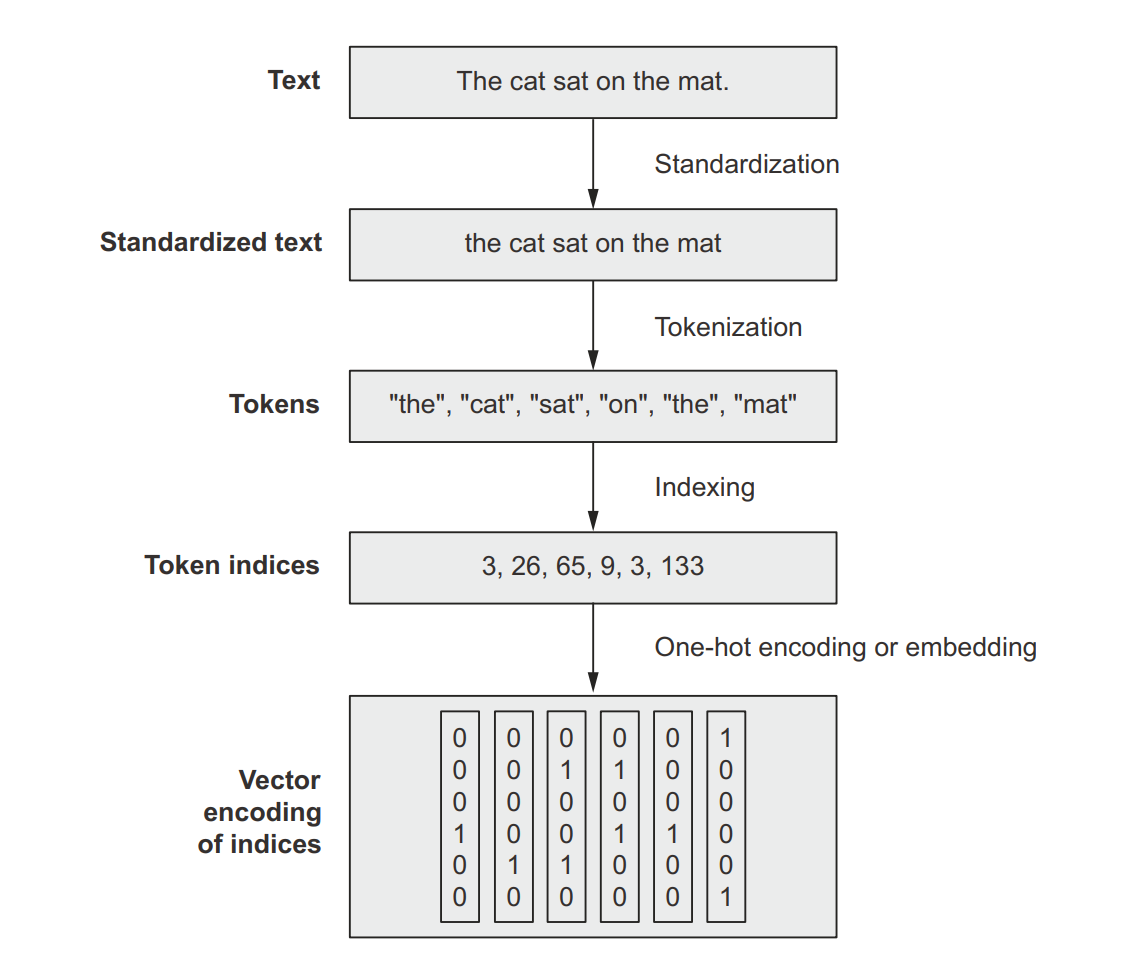

## BAG OF WORDS APPROACH (WORD AS A SET)
- Individual Words(Unigram)
- Group of consecutive tokens(N-grams)

##### Unigram with Binary Encoding

In practice you will use TextVectorization layer which is efficient and fast way of doing things.
- By defauld the layer will use the setting to convert to lowercase and remove punctuation (Standardizaztion), Split on whitespace (tokenization)
- It can receive custom function for standardization and tokenization
- Call adapt method to index the vocabulary of a text corpus

In [8]:
# define vectorizer
vectorizer = TextVectorization(max_tokens=MAX_TOKENS, output_mode='multi_hot')

In [9]:
# prepare a dataset that only yields raw text inputs no labels
text_only_train_ds = train_dataset.map(lambda x, y: x)

# use the dataset to index the dataset vocabulary via the adapt() method
vectorizer.adapt(text_only_train_ds)

In [10]:
# prepare the processed versions of our training validation and test dataset
train_ds = train_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)
val_ds = val_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)
test_ds = test_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)

In [11]:
inspect_dataset(train_ds)

inputs.shape:  (32, 10000)
inputs.dtype:  <dtype: 'float32'>
targets.shape:  (32,)
targets.dtype:  <dtype: 'int32'>

Label: 0
Sample: [1. 1. 1. ... 0. 0. 0.]


In [12]:
inspect_dataset(val_ds)

inputs.shape:  (32, 10000)
inputs.dtype:  <dtype: 'float32'>
targets.shape:  (32,)
targets.dtype:  <dtype: 'int32'>

Label: 0
Sample: [1. 1. 1. ... 0. 0. 0.]


In [13]:
inspect_dataset(test_ds)

inputs.shape:  (32, 10000)
inputs.dtype:  <dtype: 'float32'>
targets.shape:  (32,)
targets.dtype:  <dtype: 'int32'>

Label: 1
Sample: [1. 1. 1. ... 0. 0. 0.]


##### Bigrams

###### standardization, tokenization and vectorization

In [14]:
# prepare a dataset that only yield raw text inputs no labels
text_only_train_dataset = train_dataset.map(lambda x, y: x)

# use the dataset to index the dataset vocabulary via the adapt() method
vectorizer = TextVectorization(ngrams=2, max_tokens=MAX_TOKENS, output_mode='multi_hot')
vectorizer.adapt(text_only_train_dataset)

In [15]:
# create datasets
btrain_ds = train_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)
bval_ds = val_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)
btest_ds = test_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)

In [16]:
# inspect dataset
inspect_dataset(btrain_ds)

inputs.shape:  (32, 10000)
inputs.dtype:  <dtype: 'float32'>
targets.shape:  (32,)
targets.dtype:  <dtype: 'int32'>

Label: 1
Sample: [1. 1. 1. ... 0. 0. 0.]


##### Term Frequency, Inverse Document Frequency (TF-IDF)
- it weights a given term by taking term frequency, how many times the term appear in the current document and divide it by a measure of document frequency, which estimates how often the term comes up across the dataset

###### standardization, tokenization and vectorization

In [17]:
# get input text without labels
text_only_train_dataset = train_dataset.map(lambda x, y: x)



In [18]:
for text in text_only_train_dataset:
    print(text)
    break

tf.Tensor(
[b"I am very surprised by the positive comments because there were four of us that saw this at one screening and we all walked out. We personally felt that it was painfully slow to watch and couldn't sit through the whole movie. And we really tried to stick with it. In particular, those in the group who really wanted to like it because of their personal experiences with sexual orientation alienation in the school years depicted didn't like or identify with it at all. :(<br /><br />That said, it is great to see that this film really resonated with a lot of people here on the boards and with reviewers. That's the beauty of the subjective art form of film. :)"
 b'We bought the DVD set of "Es war einmal das Leben" (German) / "Once Upon a Time... Life" (English) for our bilingual kids because everyone loved the "Es war einmal der Mensch" (German) / "Once Upon a Time... Man" (English) series (us parents had seen it as kids) and it has exceeded even high expectations! The series is

In [19]:
# vectorize with tf-idf
vectorizer = TextVectorization(ngrams=2, max_tokens=MAX_TOKENS, output_mode='tf_idf')

# Skip GPU execution as dtype=tf.string is not supported for copy btn GPU & CPU
with tf.device('/CPU:0'):
    vectorizer.adapt(text_only_train_dataset)

In [20]:
# create datasets
tf_train = train_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)
tf_val = val_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)
tf_test = train_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)

In [21]:
# inspect dataset
inspect_dataset(tf_train)

inputs.shape:  (32, 10000)
inputs.dtype:  <dtype: 'float32'>
targets.shape:  (32,)
targets.dtype:  <dtype: 'int32'>

Label: 1
Sample: [1017.1185     12.557744    4.978205 ...    0.          0.
    0.      ]


## MODEL

In [22]:
# define and compile your model
model = get_model()

# get model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10000)]           0         
                                                                 
 dense (Dense)               (None, 16)                160016    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


### Model Training (Unigram)

In [23]:
# define callbacks if any
callbacks = [
    keras.callbacks.ModelCheckpoint('binary_1gram.keras', save_best_only=True)
]

In [24]:
# fit or train your model with given datasets
history_dense = model.fit(train_ds.cache(), validation_data=val_ds.cache(), epochs=EPOCHS, callbacks=callbacks)

Epoch 1/10
625/625 [==============================] - 21s 25ms/step - loss: 0.4012 - accuracy: 0.8288 - val_loss: 0.3288 - val_accuracy: 0.8712
Epoch 2/10
625/625 [==============================] - 5s 8ms/step - loss: 0.2831 - accuracy: 0.8975 - val_loss: 0.3133 - val_accuracy: 0.8804
Epoch 3/10
625/625 [==============================] - 5s 8ms/step - loss: 0.2524 - accuracy: 0.9119 - val_loss: 0.3277 - val_accuracy: 0.8832
Epoch 4/10
625/625 [==============================] - 5s 8ms/step - loss: 0.2449 - accuracy: 0.9182 - val_loss: 0.3500 - val_accuracy: 0.8754
Epoch 5/10
625/625 [==============================] - 5s 8ms/step - loss: 0.2358 - accuracy: 0.9206 - val_loss: 0.3580 - val_accuracy: 0.8836
Epoch 6/10
625/625 [==============================] - 5s 8ms/step - loss: 0.2397 - accuracy: 0.9219 - val_loss: 0.3710 - val_accuracy: 0.8796
Epoch 7/10
625/625 [==============================] - 5s 8ms/step - loss: 0.2358 - accuracy: 0.9244 - val_loss: 0.3814 - val_accuracy: 0.8782
Epoc

#### Evaluation

In [25]:
model = keras.models.load_model('binary_1gram.keras')

In [26]:
print(f"Test acc: {model.evaluate(test_ds)[1]:.3f}")

782/782 [==============================] - 45s 57ms/step - loss: 0.3070 - accuracy: 0.8791
Test acc: 0.879


In [27]:
df = pd.DataFrame(data=history_dense.history)
df.describe()

,loss,accuracy,val_loss,val_accuracy
count,10.000000,10.000000,10.000000,10.000000
mean,0.258390,0.910310,0.361463,0.877780
std,0.052744,0.030002,0.030721,0.004006
min,0.223773,0.828850,0.313312,0.871200
25%,0.235788,0.913512,0.334100,0.875600
50%,0.238175,0.921250,0.364514,0.877300
75%,0.250553,0.924425,0.390281,0.880200
max,0.401188,0.928300,0.396291,0.883600


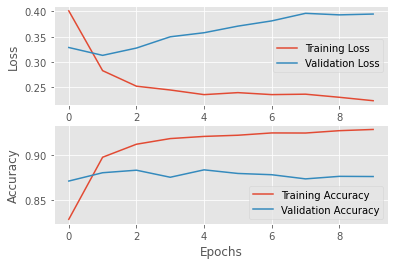

In [28]:
plot_loss_accuracy(history_dense.history,IMDB_DENSE_OUTPUT)

### Model Training (Bigram)

In [29]:
bigram_model = get_model()
bigram_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10000)]           0         
                                                                 
 dense_2 (Dense)             (None, 16)                160016    
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [30]:
callbacks = [keras.callbacks.ModelCheckpoint('bigram_model.keras', save_best_only=True)]

In [31]:
history_bigram_dense = bigram_model.fit(btrain_ds.cache(), validation_data=bval_ds, callbacks=callbacks, epochs=EPOCHS)

Epoch 1/10
625/625 [==============================] - 10s 15ms/step - loss: 0.3921 - accuracy: 0.8344 - val_loss: 0.2938 - val_accuracy: 0.8834
Epoch 2/10
625/625 [==============================] - 6s 9ms/step - loss: 0.2644 - accuracy: 0.9050 - val_loss: 0.3021 - val_accuracy: 0.8874
Epoch 3/10
625/625 [==============================] - 6s 9ms/step - loss: 0.2396 - accuracy: 0.9183 - val_loss: 0.3209 - val_accuracy: 0.8876
Epoch 4/10
625/625 [==============================] - 6s 9ms/step - loss: 0.2316 - accuracy: 0.9255 - val_loss: 0.3507 - val_accuracy: 0.8876
Epoch 5/10
625/625 [==============================] - 6s 10ms/step - loss: 0.2166 - accuracy: 0.9290 - val_loss: 0.3509 - val_accuracy: 0.8842
Epoch 6/10
625/625 [==============================] - 6s 10ms/step - loss: 0.2133 - accuracy: 0.9347 - val_loss: 0.3639 - val_accuracy: 0.8820
Epoch 7/10
625/625 [==============================] - 6s 10ms/step - loss: 0.2171 - accuracy: 0.9355 - val_loss: 0.3847 - val_accuracy: 0.8818
E

#### Evaluation

#### Testing

In [32]:
model = keras.models.load_model('bigram_model.keras')
print(f"Test acc: {model.evaluate(btest_ds)[1]:.3f}")

782/782 [==============================] - 11s 13ms/step - loss: 0.2802 - accuracy: 0.8912
Test acc: 0.891


#### Visualization

In [33]:
df = pd.DataFrame(data=history_bigram_dense.history)
df.describe()

,loss,accuracy,val_loss,val_accuracy
count,10.000000,10.000000,10.000000,10.000000
mean,0.240523,0.919185,0.355005,0.883420
std,0.056028,0.031507,0.038616,0.003247
min,0.207439,0.834400,0.293799,0.878400
25%,0.213031,0.920137,0.328355,0.881650
50%,0.216862,0.931800,0.357411,0.882700
75%,0.237592,0.935325,0.386695,0.886600
max,0.392066,0.937650,0.398977,0.887600


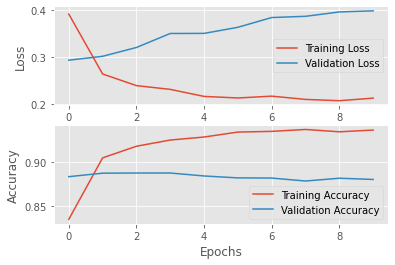

In [34]:
plot_loss_accuracy(history_bigram_dense.history,IMDB_DENSE_OUTPUT)

with bigram, hence local order is pretty important

### Model Training (TF-IDF)

In [35]:
# get model
tf_model = get_model()
tf_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10000)]           0         
                                                                 
 dense_4 (Dense)             (None, 16)                160016    
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [36]:
# callbacks
callbacks = [keras.callbacks.ModelCheckpoint('tf_model.keras', save_best_only=True)]

# train
tf_history = model.fit(tf_train.cache(), validation_data=tf_val.cache(), epochs=EPOCHS, callbacks=callbacks)

Epoch 1/10
625/625 [==============================] - 11s 18ms/step - loss: 0.4929 - accuracy: 0.8860 - val_loss: 0.3271 - val_accuracy: 0.8910
Epoch 2/10
625/625 [==============================] - 5s 8ms/step - loss: 0.2984 - accuracy: 0.8946 - val_loss: 0.3545 - val_accuracy: 0.8808
Epoch 3/10
625/625 [==============================] - 6s 9ms/step - loss: 0.2760 - accuracy: 0.8997 - val_loss: 0.3490 - val_accuracy: 0.8824
Epoch 4/10
625/625 [==============================] - 6s 9ms/step - loss: 0.2637 - accuracy: 0.9016 - val_loss: 0.3985 - val_accuracy: 0.8792
Epoch 5/10
625/625 [==============================] - 8s 13ms/step - loss: 0.2642 - accuracy: 0.9017 - val_loss: 0.4832 - val_accuracy: 0.8600
Epoch 6/10
625/625 [==============================] - 5s 7ms/step - loss: 0.2511 - accuracy: 0.9061 - val_loss: 0.4591 - val_accuracy: 0.8690
Epoch 7/10
625/625 [==============================] - 5s 8ms/step - loss: 0.2505 - accuracy: 0.9059 - val_loss: 0.3724 - val_accuracy: 0.8806
Epo

### Evaluation

In [37]:
model = keras.models.load_model('tf_model.keras')
print(f'Test accuracy: {model.evaluate(tf_test)[1]:.3f}')

625/625 [==============================] - 9s 13ms/step - loss: 0.2067 - accuracy: 0.9294
Test accuracy: 0.929


In [38]:
df = pd.DataFrame(data=tf_history.history)
df.describe()

,loss,accuracy,val_loss,val_accuracy
count,10.000000,10.000000,10.000000,10.000000
mean,0.283594,0.901885,0.395120,0.876240
std,0.075439,0.007139,0.049367,0.008531
min,0.241352,0.886050,0.327110,0.860000
25%,0.249831,0.900175,0.358950,0.872000
50%,0.257432,0.903300,0.389812,0.877100
75%,0.273026,0.906050,0.420401,0.880750
max,0.492937,0.910000,0.483248,0.891000


### Visualization

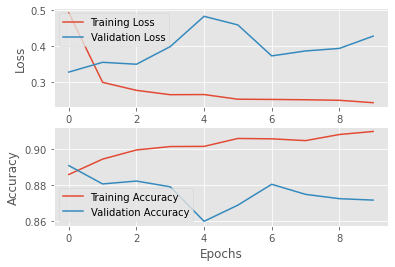

In [39]:
plot_loss_accuracy(tf_history.history,IMDB_DENSE_OUTPUT)

## Exporting a Model that process raw strings

## Inferencing

## THE SEQUENCE MODEL APPROACH  (WORDS AS A SEQUENCE)


### Config

In [50]:
# In order to keep a managable input size, we will truncate the inputs after the first 600 words
# this is a reasonable choice, since the average review length is 233 words, and only 5% of 
# reviews are longer than 600 words
MAX_LENGTH = 300
EMBEDDING_DIM = 256

### Sequence data processiong (One hot encoding

In [41]:
# Standardization, tokenization and vectorization
vectorizer = TextVectorization(max_tokens=MAX_TOKENS, output_mode='int', output_sequence_length=MAX_LENGTH)
vectorizer.adapt(text_only_train_dataset)

train_ds = train_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)
val_ds = val_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)
test_ds = test_dataset.map(lambda x, y: (vectorizer(x), y), num_parallel_calls=MULTIPLE_CPU)

In [42]:
inspect_dataset(train_ds)

inputs.shape:  (32, 300)
inputs.dtype:  <dtype: 'int64'>
targets.shape:  (32,)
targets.dtype:  <dtype: 'int32'>

Label: 0
Sample: [  31    2  452   10   14  651    6  118   43    4  157 1974   18   10
  151   12   76   27   84   19    9    1   13    7    4   83  996    5
    2  715    1    1    7  173    4 1040   12  159   56   51  332   54
  248   33 1781    1   13    2  434 1310    7    2  167    5    2   87
   18    5    1   42    4  170    1   13    2  223    7  712    3  579
   32  532 9618  641    8    4 4167   41   34  162    1   13    2   64
    7    2  358  148    9  216   27    2 1781 1247  223    3  196   27
    9   95   27 3431   13   10   42  421    4  749  199 1491 1955    3
   17    4  157  677  172    6   81  141  157    3   22    4    1   13
   32  320   23  303    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0   

### Word Embeddings
- There are two ways to obtain word embeddings
    1. Learn word embeddings jointly with the main task (starts with random word vector)
    2. Load into your model word embeddings that were precomputed using a different machine learning task (pretrained word embeddings)

#### Learn word embeddings with Embedding Layer
- The Embedding layer takes at least two args:
    1. The number f possible tokens. 
    2. The dimensionality of the embeddings.

### MODEL

In [64]:
# mask_zero param is used to perform input masking which will skip some tokens in time t
def get_lstm_with_embeddings(max_tokens=MAX_TOKENS, hidden_dim=32, mask_zero=False):
    # define
    inputs = keras.Input(shape=(None,), dtype='int64')
    # embedded = tf.one_hot(inputs, depth=max_tokens) # encode the intergers into binary 20000 dimension vector
    embedded = layers.Embedding(input_dim=max_tokens, 
                                output_dim=EMBEDDING_DIM, 
                                mask_zero=mask_zero)(inputs)
    x = layers.Bidirectional(layers.LSTM(hidden_dim))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    
    # compile
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    # return
    return model

In [43]:
def get_lstm(max_tokens=MAX_TOKENS, hidden_dim=32):
    # define
    inputs = keras.Input(shape=(None,), dtype='int64')
    embedded = tf.one_hot(inputs, depth=max_tokens) # encode the intergers into binary 20000 dimension vector
    x = layers.Bidirectional(layers.LSTM(hidden_dim))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    
    # compile
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    # return
    return model

### Train

In [44]:
model = get_lstm()
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, None, 10000)       0         
                                                                 
 bidirectional (Bidirectiona  (None, 64)               2568448   
 l)                                                              
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,568,513
Trainable params: 2,568,513
Non-trainable params: 0
_________________________________________________

In [45]:
callbacks = [keras.callbacks.ModelCheckpoint('one_hot_bidir_lstm.keras', save_best_only=True)]
history_lstm = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/10
625/625 [==============================] - 512s 800ms/step - loss: 0.5261 - accuracy: 0.7473 - val_loss: 0.3620 - val_accuracy: 0.8534
Epoch 2/10
625/625 [==============================] - 489s 782ms/step - loss: 0.3558 - accuracy: 0.8705 - val_loss: 0.3098 - val_accuracy: 0.8742
Epoch 3/10
625/625 [==============================] - 433s 692ms/step - loss: 0.3039 - accuracy: 0.8892 - val_loss: 0.3085 - val_accuracy: 0.8800
Epoch 4/10
625/625 [==============================] - 519s 829ms/step - loss: 0.2489 - accuracy: 0.9089 - val_loss: 0.3140 - val_accuracy: 0.8730
Epoch 5/10
625/625 [==============================] - 469s 750ms/step - loss: 0.2252 - accuracy: 0.9191 - val_loss: 0.3615 - val_accuracy: 0.8762
Epoch 6/10
625/625 [==============================] - 443s 709ms/step - loss: 0.1951 - accuracy: 0.9293 - val_loss: 0.3299 - val_accuracy: 0.8688
Epoch 7/10
625/625 [==============================] - 457s 730ms/step - loss: 0.1748 - accuracy: 0.9392 - val_loss: 0.3876 -

### Evaluation

In [46]:
# read train history
df = pd.DataFrame(history_lstm.history)
df.describe()

,loss,accuracy,val_loss,val_accuracy
count,10.000000,10.000000,10.000000,10.000000
mean,0.243387,0.906265,0.357185,0.866120
std,0.124531,0.062590,0.044122,0.013076
min,0.121811,0.747300,0.308532,0.839600
25%,0.156943,0.894125,0.317990,0.857200
50%,0.210121,0.924175,0.361743,0.870900
75%,0.290183,0.944800,0.375655,0.875700
max,0.526149,0.958450,0.450726,0.880000


In [47]:
# load your model
model = keras.models.load_model('one_hot_bidir_lstm.keras')
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, None, 10000)       0         
                                                                 
 bidirectional (Bidirectiona  (None, 64)               2568448   
 l)                                                              
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,568,513
Trainable params: 2,568,513
Non-trainable params: 0
_________________________________________________

In [48]:
# run a test
print(f'{model.evaluate(test_ds)[1]:.3f}')

782/782 [==============================] - 288s 366ms/step - loss: 0.3224 - accuracy: 0.8716
0.872


### Visualization

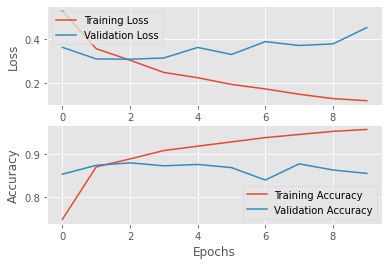

In [49]:
plot_loss_accuracy(history_lstm.history, IMDB_LSTM_OUTPUT)

### Train (Embedding)

In [54]:
inspect_dataset(train_ds)

inputs.shape:  (32, 300)
inputs.dtype:  <dtype: 'int64'>
targets.shape:  (32,)
targets.dtype:  <dtype: 'int32'>

Label: 0
Sample: [  10  237   53  752   33    2 1102  771   80   48   68  694    5  169
   12  207   11   31   29 3094    3   72   32 2408   46   72 1224  405
   12    9   14 2133  576    6  104    3  400  845  140    2  219   18
    3   72   63  782    6 1190   17    9    8  795  144    8    2  589
   37   63  461    6   39    9   80    5   65  912 2444   17  869    1
 8770    8    2  407  149 2300  153   39   41 3548   17    9   31   32
   13   13   12  288    9    7   84    6   67   12   11   20   63    1
   17    4  170    5   85  131   21    2 8756    3   17 1823  174    2
  894    5    2    1  525  801    5   20    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0   

In [56]:
model = get_lstm_with_embeddings()
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 256)         2560000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               73984     
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,634,049
Trainable params: 2,634,049
Non-trainable params: 0
_________________________________________________

In [57]:
callbacks = [
    keras.callbacks.ModelCheckpoint('lstm_with_embeddings.keras', save_best_only=True)
]
history_lstm_embeddings = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/10
625/625 [==============================] - 94s 144ms/step - loss: 0.4804 - accuracy: 0.7852 - val_loss: 0.4100 - val_accuracy: 0.8300
Epoch 2/10
625/625 [==============================] - 66s 105ms/step - loss: 0.3253 - accuracy: 0.8784 - val_loss: 0.3164 - val_accuracy: 0.8794
Epoch 3/10
625/625 [==============================] - 60s 96ms/step - loss: 0.2694 - accuracy: 0.9026 - val_loss: 0.3239 - val_accuracy: 0.8676
Epoch 4/10
625/625 [==============================] - 57s 91ms/step - loss: 0.2271 - accuracy: 0.9205 - val_loss: 0.4067 - val_accuracy: 0.8566
Epoch 5/10
625/625 [==============================] - 59s 93ms/step - loss: 0.1872 - accuracy: 0.9338 - val_loss: 0.3423 - val_accuracy: 0.8778
Epoch 6/10
625/625 [==============================] - 71s 113ms/step - loss: 0.1535 - accuracy: 0.9460 - val_loss: 0.3828 - val_accuracy: 0.8744
Epoch 7/10
625/625 [==============================] - 61s 97ms/step - loss: 0.1262 - accuracy: 0.9566 - val_loss: 0.4333 - val_accura

### Evaluation

In [58]:
df = pd.DataFrame(history_lstm_embeddings.history)
df.describe()

,loss,accuracy,val_loss,val_accuracy
count,10.000000,10.000000,10.000000,10.000000
mean,0.202936,0.923700,0.410635,0.864640
std,0.127606,0.057988,0.075091,0.014199
min,0.071819,0.785200,0.316417,0.830000
25%,0.109781,0.907112,0.352408,0.861000
50%,0.170378,0.939900,0.408382,0.867900
75%,0.258790,0.962038,0.433726,0.873100
max,0.480404,0.977200,0.531940,0.879400


In [59]:
# load a model and run a test
model = keras.models.load_model('lstm_with_embeddings.keras')
print(f'{model.evaluate(test_ds)[1]:.3f}')

782/782 [==============================] - 54s 67ms/step - loss: 0.3444 - accuracy: 0.8630
0.863


### Visualization

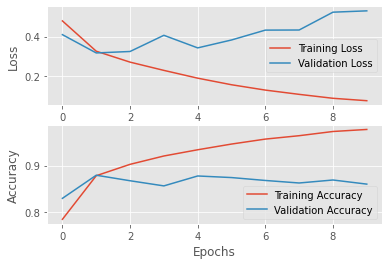

In [60]:
plot_loss_accuracy(history_lstm_embeddings.history, IMDB_GRU_OUTPUT)

### Train (masked embeddings)

In [66]:
inspect_dataset(train_ds)

inputs.shape:  (32, 300)
inputs.dtype:  <dtype: 'int64'>
targets.shape:  (32,)
targets.dtype:  <dtype: 'int32'>

Label: 1
Sample: [ 715 6917   37  460  334  169    1   97   15    4 4310  366    3 4658
  271   51  856  169  246    4  302    1    6    2  875  832    2 4108
    3    8   12   61    1 3581    5 3521 1417    6    1    2 1329  894
    5    2 4986 1561   59   33    2 1409  433  379   44    2   18    7
   63  445   21    4  272   64  271   51  447    1   12  344    5 1796
   24    8  867  344   12  465  697   65   61   17    4 1350 1944   12
   62    2   61   76  191   98  270    2  624    7    1  135   15    2
  176  482   33 4537 3524  616  234    7  654    6    1 1341  942    4
 6601  856    7    2 1218    5 4053    1    8    2  217    5    1 2855
   18   12  216  702    8    4 1090    5  144   37   63 1297    2  875
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0   

In [68]:
model = get_lstm_with_embeddings(mask_zero=True)
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_4 (Embedding)     (None, None, 256)         2560000   
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               73984     
 nal)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2,634,049
Trainable params: 2,634,049
Non-trainable params: 0
_________________________________________________

In [69]:
callbacks = [keras.callbacks.ModelCheckpoint('masked_embeddings.keras', save_best_only=True)]
history_masked = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/10
625/625 [==============================] - 85s 125ms/step - loss: 0.4185 - accuracy: 0.8066 - val_loss: 0.2953 - val_accuracy: 0.8800
Epoch 2/10
625/625 [==============================] - 72s 115ms/step - loss: 0.2617 - accuracy: 0.8969 - val_loss: 0.3042 - val_accuracy: 0.8772
Epoch 3/10
625/625 [==============================] - 69s 110ms/step - loss: 0.2021 - accuracy: 0.9244 - val_loss: 0.3063 - val_accuracy: 0.8816
Epoch 4/10
625/625 [==============================] - 62s 99ms/step - loss: 0.1579 - accuracy: 0.9434 - val_loss: 0.3274 - val_accuracy: 0.8772
Epoch 5/10
625/625 [==============================] - 65s 104ms/step - loss: 0.1238 - accuracy: 0.9561 - val_loss: 0.3870 - val_accuracy: 0.8772
Epoch 6/10
625/625 [==============================] - 70s 112ms/step - loss: 0.0934 - accuracy: 0.9668 - val_loss: 0.4469 - val_accuracy: 0.8672
Epoch 7/10
625/625 [==============================] - 65s 104ms/step - loss: 0.0712 - accuracy: 0.9759 - val_loss: 0.4659 - val_acc

### Evaluate

In [70]:
df = pd.DataFrame(history_masked.history)
df.describe()

,loss,accuracy,val_loss,val_accuracy
count,10.000000,10.000000,10.000000,10.000000
mean,0.144581,0.943245,0.428802,0.867720
std,0.122159,0.056625,0.123659,0.012758
min,0.028797,0.806600,0.295288,0.848600
25%,0.055832,0.929162,0.311550,0.856550
50%,0.108591,0.961450,0.416938,0.872200
75%,0.191059,0.981000,0.528967,0.877200
max,0.418470,0.991300,0.617198,0.881600


In [71]:
# load a model and run a test
model = keras.models.load_model('masked_embeddings.keras')
print(f'{model.evaluate(test_ds)[1]:.3f}')

782/782 [==============================] - 32s 35ms/step - loss: 0.3092 - accuracy: 0.8720
0.872


### Visualization

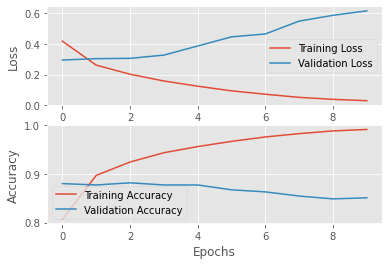

In [72]:
plot_loss_accuracy(history_masked.history, IMDB_MASKED_OUTPUT)